In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from scipy import ndimage
from skimage.util.shape import view_as_windows
import random

In [2]:
# Read sample data.
img = Image.open('../sample_data/ImageSlice.png')

In [3]:
# Turn image into a Numpy array.
imgArray = np.array(img, dtype=np.uint8)

In [4]:
# Create rectangle point, width, and height.
x, y, w, h = 300, 200, 100, 100

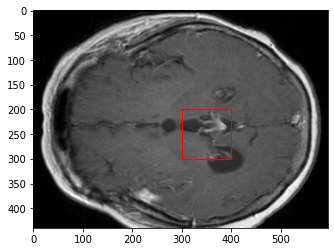

In [5]:
# Take the rectangle and highlight image.
fig, ax = plt.subplots(1)
ax.imshow(imgArray)
rect = Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

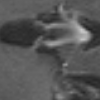

In [6]:
# Crop image from highlighted rectangle.
cropped = img.crop((x, y, x+w, h+y))
cropped

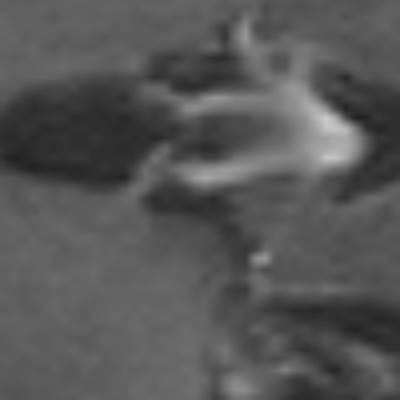

In [7]:
# Blow up image for visualization.
cropped.resize((w*4, h*4))

In [8]:
imgArray = imgArray[:,:,0]
imgArray.shape

(440, 596)

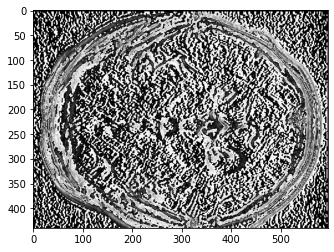

In [9]:
# Define kernel for x differences
kx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
# Define kernel for y differences
ky = np.array([[1,2,1] ,[0,0,0], [-1,-2,-1]])
# Perform x convolution
dx=ndimage.convolve(imgArray,kx)
# Perform y convolution
dy=ndimage.convolve(imgArray,ky)
plt.imshow(dx,cmap=plt.cm.gray)
plt.show()

x=204 y=235 l=177 window_shape=(264, 420, 177, 177)


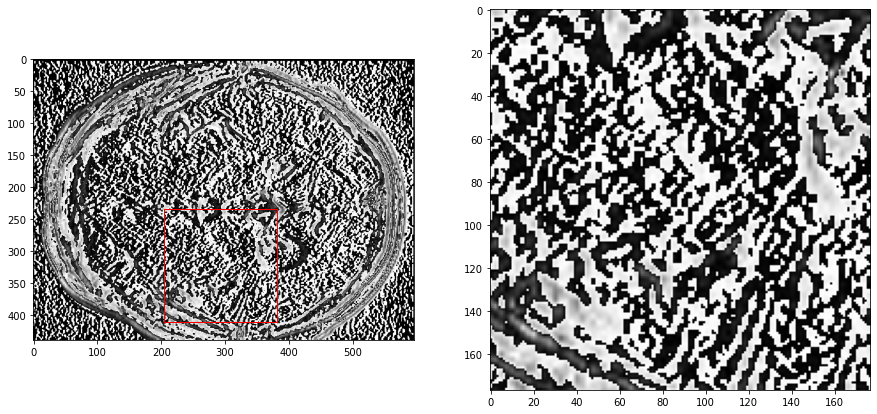

In [16]:
window_size = random.randint(100,300)
windows = view_as_windows(dx, (window_size,window_size))
y, x = random.randint(0, windows.shape[0] - 1), random.randint(0, windows.shape[1] - 1)
print('x={} y={} l={} window_shape={}'.format(x, y, window_size, windows.shape))
dx_patch = windows[y, x]
fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(dx,cmap=plt.cm.gray)
rect = Rectangle((x, y), window_size, window_size, linewidth=1, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)
ax[1].imshow(dx_patch,cmap=plt.cm.gray)
plt.show()